# **Replication of Dahlberg, Edmark and Lundqvist - Ethnic Diversity and Preferences for Redistribution (2012)**


### **Introduction**

Since the late 20th century especially West and North European countries experienced an increasing number of immigration. While the first immigrants came out of economic reasons, the situation started to change in the 1980's as more and more refugees arrived, seeking for protection. A large share of immigrants in a population does not only have economic and political effects but also changes the society. The attitude of the local population towards immigrants has become more and more negative over the last years. There are several reasons but one of them might be that immigrants, especially refugees from countries outside Europe, differ from the native population in their language, culture and religion and the native population might be prejudiced about other ethnicities. Additionally, refugees are typically dependent on welfare payments when they arrive in Europe. Therefore, it is interesting to ask the following question:

How does an increased ethnic heterogeneity in their neighbourhood change natives' preferences for redistribution?

Matz Dahlberg, Karin Edmark and Heléne Lundqvist address this issue concerning the Swedish population in their paper [Ethnic Diversity and Preferences for Redistribution (2012)](#paper). They study immigration to Sweden in the 1980's and 90's and try to estimate the causal effect of ethnic diversity in the Swedish society on natives' preferences for redistribution. Their definition of immigrants is "the share of the population with a non-OECD citizenship", more precisely "those with non-OECD citizenship according to OECD membership status before 1994 and those with a Turkish citizenship" as they expect them to be "more ethnically different from native Swedes than OECD citizens" (cf. [Dahlberg et al. 2012, p. 48](#paper)). They use an instrumental variables approach and therefore make use of a nationwide refugee placement program that was in place from 1985 to 1994 and distributed the immigrants across the single municipalities. This program is assumed to be exogenous conditional on certain municipal characteristics that determined the placement of refugees. Their result is a negative, statistically significant effect of an increase in immigration on natives' preferred level of social benefits, especially pronounced among typical welfare contributors.

Within my student project I am going to replicate the main results of their work using Python. The original graphic and regression data of the authors has been provided by the Swedish National Data Service. As they contain sensitive information I am not allowed to upload them in my repository. So for this Jupyter Notebook to work I uploaded two synthetic data files with the same structure as the original ones but with zero entries everywhere.

#### **Structure of the Project**

Section 1 starts with the background of the framework, giving some general information about the issue of immigration to Sweden as well as the refugee placement program used by the authors. In Section 2 I apply the potential outcome framework to the problem, specify the identification strategy used and deal with potential threats to the identification of a causal effect. These include threats concerning the exogeneity assumption of the instrument that have already been raised by the authors as well as further threats I encountered during my work on the project. Next, a description and analysis of the data set used by the authors follow in Section 3 and 4, respectively. Section 5 replicates the treatment effect estimations of the original paper which consist of an average treatment effect estimation as well as a heterogeneity analysis with respect to individual welfare dependency. 
This will be followed by a placebo analysis with respect to treatment in Section 6 and sensitivity analyses to deal with the potential problem of the exogeneity assumption in Section 7, both reproduced from the paper as well. To examine the additional threats to validity I came across, I perform a simulation study in Section 8. Finally, Section 9 provides a conclusion drawn from my work.

In [1]:
# load packages needed
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pathlib
import seaborn as sns 
import econtools 
import econtools.metrics as mt

from pathlib import Path
from econtools import read, outreg, table_statrow, write_notes
from random import randint
from auxiliary import *
from regressions import *

In [2]:
# read in graphic and regression data files
# if original data is not available on your computer then read in synthetic files 
grafdata = Path('C:/Users/Caroline/Documents/Studium/Master/2. Semester/Microeconometrics/Student Project/Daten/Grafdata/0906graf.csv')
regdata = Path('C:/Users/Caroline/Documents/Studium/Master/2. Semester/Microeconometrics/Student Project/Daten/Regdata/0906reg.csv')

if grafdata.is_file():
    df_fig = pd.read_csv(grafdata, sep = ';' , decimal = ',')
    df_fig = df_fig.astype(np.float)
else:
    df_fig = pd.read_csv('data/grafdata_synthetic.csv')
    df_fig = df_fig.astype(np.float)

    
if regdata.is_file():
    df = pd.read_csv(regdata, sep = ';', decimal = ',')
    df = df.astype(np.float)
else:
    df = pd.read_csv('data/regdata_synthetic.csv')
    df = df.astype(np.float)


### **Table of Contents**

**1. [Background](#chap1)** 
    
$\quad$ **1.1** [Immigration to Sweden](#chap1.1)
    
$\quad$ **1.2** [The Refugee Placement Program](#chap1.2)
    
**2. [Potential Outcome Framework and Identification Strategy](#chap2)**
    
$\quad$ **2.1** [Threats to Identification](#chap2.1)

**3. [Description of the Data](#chap3)**

**4. [Analysis of the Data](#chap4)**

**5. [Treatment Effect Estimation](#chap5)**

$\quad$ **5.1** [Average Treatment Effect](#chap5.1)
    
$\quad$ **5.2** [Heterogeneous Treatment Effects](#chap5.2)
    
**6. [Placebo Analysis](#chap6)**

**7. [Sensitivity Analyses](#chap7)**

$\quad$ **7.1** [Potential bias due to refugees moving to another municipality](#chap7.1)
    
$\quad$ **7.2** [Potential bias due to municipalities refusing to take on refugees](#chap7.2)

$\quad$ **7.3** [Potential bias due to natives moving to another municipality as a result of the refugee inflow](#chap7.3)

**8. [Simulation Study](#chap8)**

$\quad$ **8.1** [Investigation of first stage estimation results](#chap8.1)

$\quad$ **8.2** [Investigation of second stage estimation results](#chap8.2)

**9. [Conclusion](#chap9)**

[References](#ref)

### **1. Background** <a id='chap1'></a>

#### **1.1 Immigration to Sweden** <a id='chap1.1'></a>

From World War II onward, Sweden has developed from a nation of emigration to a nation of immigration.

In the 1950's and 60's the main source of immigration was the recruitment of migrant workers. Sweden's economy grew rapidly in the post-war period and the small country was not able to provide the required work force on its own. So the Nordic countries agreed upon a common labour market such that most of the labour migrants arrived from the other Nordic countries, especially Finland. But also workers from other economically weaker European countries were allowed to immigrate to Sweden. As the demand for labour declined with a slow down of the Swedish economy in the early 1970's, also the labour immigration to Sweden did. ([cf. Wickström 2015](#wickström))

Instead, political refugees started to arrive in the 1980's and 90's, seeking for protection from war and political persecution in their home countries. The largest share of them came from the Middle East, especially Iran and Iraq, and former Yugoslavia due to the Yugoslavian wars ([cf. Statistics Sweden](#scb)). They were attracted by high living standards and a generous immigration policy, promoting multiculturalism and ethnic diversity ([cf. Wickström 2015](#wickström)).

Figure 1 illustrates this increase in immigration as it plots the change in the share of the Swedish population with a foreign citizenship for the period analysed by the authors. After a slight decrease from 1980 to 1986 the share increased by more than one percentage point in the next years with a maximum of 5.2 percent in 1994. This amounts to a total increase of nearly 100 000 foreign citizens within roughly 15 years.

In [3]:
# delete year 1998 as there are no observations
df_fig = df_fig[df_fig.year != 1998] 
# sort data
df_fig = df_fig.sort_values(['kommun', 'year'], ascending = [True, True])

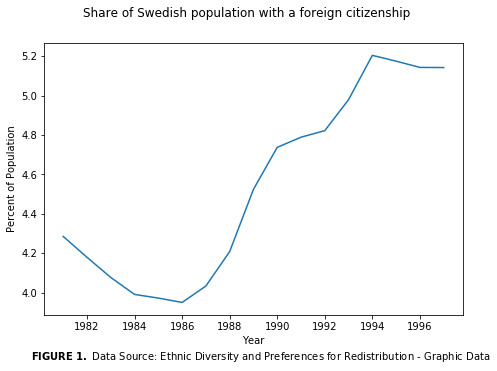

In [4]:
# group by year and sum up number of immigrants in the single categories
fig1 = df_fig.groupby(['year'], sort = True)['nonOECD', 'kombef', 'norden', 'afrika', 'asien', 'latam', 'europa_notnorden', 'nordam_oceanien', 'flland'].sum()

# compute share of population with a foreign citizenship and add it to dataframe
foreign = fig1['norden'] + fig1['afrika'] + fig1['asien'] + fig1['latam'] + fig1['europa_notnorden'] + fig1['nordam_oceanien']
fig1.insert(loc = 9, column = 'foreign', value = foreign)
foreign_share = (foreign/fig1['kombef'])*100
fig1.insert(loc = 10, column = 'foreign_share', value = foreign_share)

# create plot 
fig, ax = plt.subplots(figsize=(7.5, 5))
ax.plot(fig1['foreign_share'])
ax.set_ylabel('Percent of Population')
ax.set_xlabel('Year')
plt.suptitle('Share of Swedish population with a foreign citizenship')
fig.text(0.1, 0,'$\\bf{FIGURE}$ $\\bf{1.}$ Data Source: Ethnic Diversity and Preferences for Redistribution - Graphic Data');

# compute total increase in number of foreign citizens
#fig1.loc[1997, 'foreign'] - fig1.loc[1981, 'foreign']

As the authors define immigrants as people with a non-OECD citizenship, Figure 2 plots the evolution of the share of the population with a non-OECD citizenship over time. One can see an increase from 1.5 percent in 1981 to more than 3.5 percent in 1994. Compared with Figure 1 this indicates that people with a non-OECD citizenship make up a large share of foreign citizens in Sweden and thus, the ethnic heterogeneity increased significantly in the period analysed.

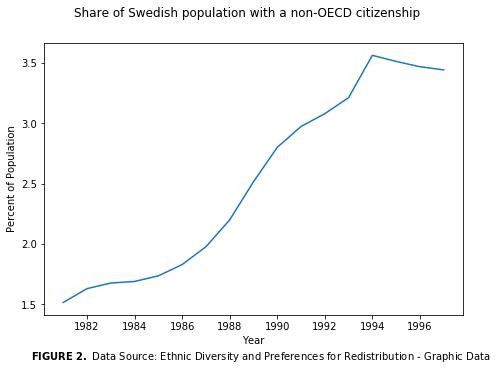

In [5]:
# compute share of population with non-OECD citizenship and add it to dataframe
nonOECD_share = (fig1['nonOECD']/fig1['kombef'])*100
fig1.insert(loc = 9, column = 'nonOECD_share', value = nonOECD_share)

# create plot 
fig, ax = plt.subplots(figsize=(7.5, 5))
ax.plot(fig1['nonOECD_share'])
ax.set_ylabel('Percent of Population')
ax.set_xlabel('Year')
plt.suptitle('Share of Swedish population with a non-OECD citizenship')
fig.text(0.1, 0,'$\\bf{FIGURE}$ $\\bf{2.}$ Data Source: Ethnic Diversity and Preferences for Redistribution - Graphic Data');

#### **1.2 The Refugee Placement Program** <a id='chap1.2'></a>

As a response to the increased immigration, a nationwide refugee placement program was in place between 1985 and 1994. In  that period, the Swedish Immigration Board took responsibility for refugee issues and created a settlement policy that placed all political immigrants, except those who arrived for family reunification. The intention was to break the concentration to large city regions and distribute them equally across the country, also paying attention to local labour market and housing conditions. The refugees were not allowed to choose themselves where to settle but the assignment was managed by the Immigration Board and determined through contracts with the single municipalities. Therefore, the number of received refugees is not exogenous but correlated with certain municipal characteristics. However, the refugees were allowed to express preferences of residence and most of them applied for one of the three big Swedish cities, Stockholm, Malmö and Göteborg. If the number of refugees exceeded the number of available places in a municipality, the municipalities chose which ones to take up. This selection might have been determined by characteristics like language skills, qualifications and family size of the immigrants. Additionally, the refugees did not have to stay in the assigned municipality but were allowed to move whenever they wanted. At the beginning of the program only 60 municipalities were contracted but as immigration increased rapidly in the late 1980's, also the number of participating municipalities did. In 1989, 277 of the then 284 municipalities signed contracts with the Immigration Board. As a compensation for the expenditures arising with the receipt of program refugees the local governments received financial support from the Immigration Board. ([cf. Edin et al. 2003](#edin)) Unfortunately, it seems that the placement program was not always handled that strictly. Edin et al. report that the "the strictest application of the assignment policy was between 1987 and 1991" where "the placement rate [...] was close to 90 percent" ([cf. Edin et al. 2003, p. 333](#edin)). In other years, the coverage probability seems to have been significantly lower.

### **2. Potential Outcome Framework and Identification Strategy** <a id='chap2'></a>

To identify a causal effect in the question of interest, one can make use of the potential outcome framework formalised by Donald Rubin. In this framework, an individual is exposed to a certain treatment and one is interested in quantifying the causal effect of this treatment on an outcome variable by comparing outcomes that would result from the exposure to different treatment states. Unfortunately, one can only observe the outcome under one of the treatment states and all others are counterfactual. So one cannot compute treatment effects at the individual level but rather needs to be content with population-level causal effects. 
If the treatment assignment is random, one can take the difference in means of the outcome variables between the different treatment groups to identify the average treatment effect. If this is not the case, one needs to make further assumptions for the validity of the average treatment effect estimate.

In the available setting, the treatment corresponds to the change in the share of immigrants in a municipality between two election years and the outcome of interest is the resulting individual change in preferences for redistribution during the same period. So the treatment variable is not a binary one but one rather arrives at variable treatment intensities. Therefore, the effect of a change in the share of immigrants in a municipality on natives' preferred level of social benefits depends on the initial value of the share of immigrants and one arrives at different unit causal effects on the outcome under different initial treatment states. The average treatment effect is then defined as the average over those unit causal effects. (cf. [Angrist and Pischke](#angpisch)) The additional assumptions needed for identification and the validity of the treatment effect estimate are further discussed in Section 5.

A problem for identification is that the treatment intensity does not correspond to a randomised experiment. If immigrants can choose on their own where to settle, one generally expects a problem of endogeneity due to reverse causality when regressing preferences for redistribution on the share of immigrants in the population. An increasing number of immigrants might influence preferences for redistribution among natives but also the other way round. A municipality with a more generous view on redistribution might attract more immigrants. Therefore, an exogenous instrument for the share of immigrants in a population is needed and Dahlberg et al. make use of the number of refugees placed by the refugee placement program, denoted as refugee inflow. But as the number of refugees assigned to a municipality is determined through municipal contracts, the placement is correlated with certain municipal characteristics and some of those characteristics might also affect the individuals' view on social benefits. 

The following causal graph depicts this situation. There are two back-door paths and one of them involves unobservable variables which leads to the need of an instrumental variables approach. The other back-door path emerges after the inclusion of the instrument but can be blocked by conditioning on municipal characteristics. 

<img src="graphs/Causal_Graph.png" height="700" width="700" />


In this basic model except from the size of immigration only municipal characteristics are expected to affect individuals' preferences for redistribution. But also individual factors might influence the preferred level of social benefits leading to heterogeneous treatment effects. Therefore in a second step, the authors extend the model by including information about the individuals' social situation such as their income or wealth class or their worker type status. The reason is that people who are likely welfare contributors might have a different view on redistribution than those who are welfare dependents on their own. As a result, the causal graph for this second approach has to be adjusted as shown below. The treatment effect heterogeneity does not change the identification strategy as it still suffices to condition on municipal characteristics, but the estimate of the treatment effect is now different for different groups of welfare dependents.

<img src="graphs/Causal_Graph_2.png" height="800" width="800" />


#### **2.1 Threats to Identification** <a id='chap2.1'></a>

The identifying assumption relies on the fact that the refugee placement program is exogenous with respect to natives' preferences for redistribution. However, the authors claim that this assumption might be violated because of two reasons: refugees moving to another municipality after the initial placement and municipalities refusing to take on refugees. If those two cases occur to a large extent, the treatment effect may suffer from large bias. To investigate those problems, they perform sensitivity analyses which are replicated in Section 7.

Another problem of the identification strategy is that Dahlberg et al. do not account for the possibility that municipalities might have selected refugees on the basis of characteristics like their language skills and qualification. Admittedly, only the municipalities that were very popular with the refugees were able to select refugees on their own but especially the three big city regions might have experienced a large number of applications and were thus able to select whom to take up. The personal characteristics of the refugees considered in the selection process might on their own also influence preferences for redistribution among the native population. If immigrants are willing to assimilate to their neighbourhood by learning the language and participating in the labour market, the local population might have a less negative attitude towards them and is willing to support them in the beginning. The following causal graph indicates that it is necessary to also condition on those personal characteristics. But unfortunately, they are unobserved in the data set such that it is not possible to account for it. As a result, there is selection on unobservables and the average treatment effect estimate that only relies on observable variables is inconsistent. 

<img src="graphs/Causal_Graph_3.png" height="700" width="700" />


Moreover, the relevance of the instrument may also be a problem. As in the beginning only a few municipalities were contracted, the share of immigrants in those who did not participate is not at all affected by the instrument. Also in those periods where the program was not handled that strictly and did not place all or at least a vast majority of the incoming refugees might be problematic as then the correlation between the variable refugee inflow and the endogenous variable change in share of immigrants is too low. As a consequence there might arise a weak instruments problem in certain periods of the program, potentially leading to biased estimates of the treatment effect.

Finally, [Nekby and Pettersson-Lidbom (2016)](#nekby) claim that the variable refugee inflow in the authors' dataset is mismeasured. They say that Dahlberg et al. do not use the number of contracted refugees but measure the number of incoming refugees with the yearly payment of grants from the Immigration Board to the local governments. They argue that this is problematic as "these payments cover refugees that were targeted by the [...] program as well as other refugees that were not targeted by the placement policy" and "the grants were paid out with a considerable time lag" (cf. [Nekby and Pettersson-Lidbom 2016, p. 278](#nekby)). The measurement of the variable is unfortunately not evident from the data set but a mismeasurement of the instrument used may lead to large problems in causal inference. To investigate the effects of a measurement error, a simulation study is performed in Section 8.

### **3. Description of the Data** <a id='chap3'></a>

The authors use two types of data for their analysis. 

They use survey data from the Swedish National Election Survey Program collected every election year since the mid 1950's. It is a rotating panel that interviews eligible voters in two consecutive election periods and changes half of the sample each time. It collects information about the individuals' view on politics and social issues as well as about the respondents' background like his social situation. For a measure of the dependent variable, individuals' preferences for redistribution, Dahlberg et al. exploit a survey question on whether the respondents were "in favor of decreasing the level of social benefits." The question had to be answered with means of a five-point scale: (1) very good, (2) fairly good, (3) does not matter much, (4) rather bad, or (5) very bad. So lower values indicate strong approval of the suggestion, i.e. less preferences for redistribution. As interest lies on changes of those preferences they take the difference in individuals' responses between two survey waves and thus only take those respondents into consideration that were interviewed in both periods and did not move to another municipality in between. So in the end, the data set contains 2679 individual observations of one of the survey panels 1982/85, 1985/88, 1988/91 or 1991/94. For the main analysis, the observations of the panel period 1982/85 are further excluded as the refugee placement program had not been in place yet such that one arrives at 1917 observations.

These data are matched with data about the political, economic and social situation in the respondents' municipalities. Among others these include the explanatory variable immigrant share as well as the instrument refugee inflow, defined as the number of refugees placed by the program. Both are denoted as the share of the total municipal population and averaged over the years of the corresponding panel period, respectively.

### **4. Analysis of the Data** <a id='chap4'></a>

Before starting with the treatment effect estimation, this section provides some preliminary data analysis that especially focusses on illustrating properties of the instrument and dependent variable used.

To get an overview of the policy used as an instrument, Figure 3 illustrates the enforcement of the placement program. It shows the share of refugees placed by the program in each year grouped by the population size of the municipalities. Small-sized municipalities are those with less than 50 000 inhabitants whereas large-sized ones have a population size greater than 200 000. One can see that after the introduction of the program in 1985 most of the refugees were assigned to municipalities with small or medium population size. So obviously, the policy fulfilled the objective of breaking up the concentration of refugees to large towns and rather assigned them to smaller municipalities. 

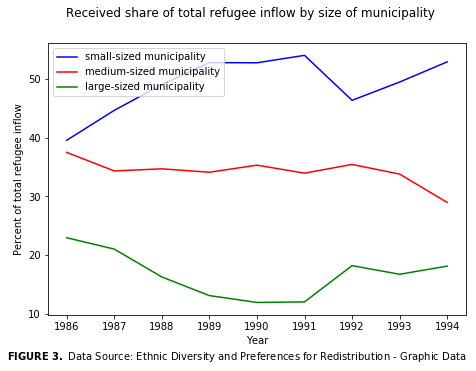

In [6]:
# create copy of the dataframe before it is adjusted
fig3 = df_fig.copy()

# only select years where refugee placement was in place
fig3 = fig3[fig3['year'] >= 1986]
fig3 = fig3[fig3['year'] <= 1994]

# define variable indicating size of municipality
fig3['townsize'] = np.nan
fig3.loc[fig3['kombef'] < 50000, 'townsize'] = 1
fig3.loc[fig3['kombef'] >= 50000, 'townsize'] = 2
fig3.loc[fig3['kombef'] > 200000, 'townsize'] = 3

# compute share of refugees placed in municipalities of corresponding size by year and add it to dataframe
fig3 = fig3.groupby(['year', 'townsize'], sort = True)['kombef', 'flykt'].sum()
for k in [1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994]:
    fig3.loc[k, 'flykt_annual'] = fig3.loc[k, 'flykt'].sum()
fig3['flykt_share'] = fig3['flykt']/fig3['flykt_annual'] * 100

# create variables for means of plotting
plot1 = fig3['flykt_share'].where(fig3.index.get_level_values('townsize') == 1).dropna().reset_index(level = 1).drop(['townsize'], axis = 1)
plot2 = fig3['flykt_share'].where(fig3.index.get_level_values('townsize') == 2).dropna().reset_index(level = 1).drop(['townsize'], axis = 1)
plot3 = fig3['flykt_share'].where(fig3.index.get_level_values('townsize') == 3).dropna().reset_index(level = 1).drop(['townsize'], axis = 1)

# create plot
fig, ax = plt.subplots(figsize = (7.5, 5))
plt.plot(plot1, 'b', plot2, 'r', plot3, 'g')
plt.suptitle('Received share of total refugee inflow by size of municipality')
ax.set_ylabel('Percent of total refugee inflow')
ax.set_xlabel('Year')
plt.legend(['small-sized municipality', 'medium-sized municipality', 'large-sized municipality'])
fig.text(0.05, 0,'$\\bf{FIGURE}$ $\\bf{3.}$ Data Source: Ethnic Diversity and Preferences for Redistribution - Graphic Data');

For the following analysis it is also interesting to know how many refugees the single municipalities contained in the data set received relative to their population size. The histogram in Figure 4 reveals that during a panel period most of the municipalities received refugees amounting to zero to two percent of their population size, with its average slightly below one percent. So the distribution of refugees seems to be very even for the municipalities analysed. However, there is one extreme value at 7.7 percent which belongs a municipality with a small population. The authors exclude this observation in their analysis and I decided to do this as well to avoid a biased estimate.

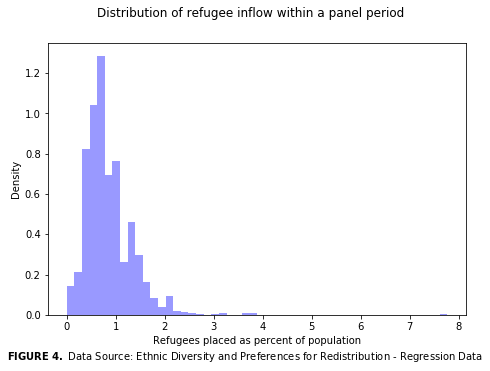

In [8]:
# create copy of dataframe before it is adjusted
df_orig2 = df.copy()

# drop observations from panel 1982-85 as placement program hadn't yet started
df_orig2 = df_orig2[df_orig2['year'] != 1985]

# create plot
fig, ax = plt.subplots(figsize=(7.5, 5))
ax = sns.distplot(df_orig2['flyktingandel'], kde = False, norm_hist = True, color = 'blue')
ax.set_ylabel('Density')
ax.set_xlabel('Refugees placed as percent of population')
plt.suptitle('Distribution of refugee inflow within a panel period')
fig.text(0.05, 0,'$\\bf{FIGURE}$ $\\bf{4.}$ Data Source: Ethnic Diversity and Preferences for Redistribution - Regression Data');


As main interest lies on individuals' preferences for redistribution, Figures 5 and 6 plot those preferences for each election year where the program was in place and the individual change in preferences between two consecutive election years, respectively. 

The preferences by year in Figure 5 indicate that there is a slight negative overall trend in support for redistribution. In 1985 only few respondents didn't care much about the question and a few more were against instead of for decreasing the level of social benefits. In 1988 slightly less inhabitants were actively against the suggestion and more of them didn't care. Finally, in 1991 and 1994 one can clearly see that relative to the first two years there is a smaller percentage of people who thought that it is a very bad idea to decrease the level of redistribution and a few more believed that it is a fairly good idea.

The individual changes in preferences in Figure 6 confirm this slight negative trend. However, around 40 percent of the respondents didn't change their response and only a few made an extreme change in either direction.

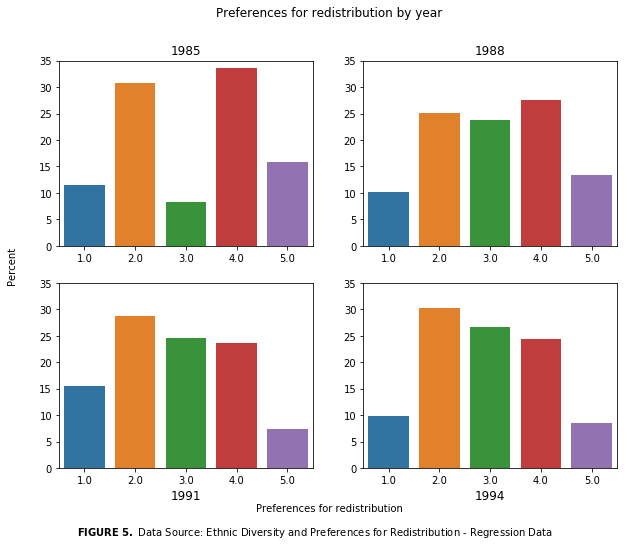

In [9]:
# create copy of dataframe before it is adjusted
df_orig = df.copy()

# create variables for preferences in the single years
PREF_1985 = df_orig['soc_bidr'].where(df_orig['year'] == 1985).dropna()
PREF_1988 = df_orig['soc_bidr'].where(df_orig['year'] == 1988).dropna()
PREF_1991 = df_orig['soc_bidr'].where(df_orig['year'] == 1991).dropna()
PREF_1994 = df_orig['soc_bidr'].where(df_orig['year'] == 1994).dropna()


# create barplots for each year
fig = plt.figure(figsize=(10, 7.5))
plt.suptitle('Preferences for redistribution by year' )

plt.subplot(2, 2, 1)
sns.barplot(x = PREF_1985, y = PREF_1985, estimator = lambda x: len(x) / len(PREF_1985) * 100, color = None)
plt.title('1985')
plt.ylim(0, 35)
plt.xlabel(None)
plt.ylabel(None)

plt.subplot(2, 2, 2)
sns.barplot(x = PREF_1988, y = PREF_1988, estimator = lambda x: len(x) / len(PREF_1988) * 100, color = None)
plt.title('1988')
plt.ylim(0, 35)
plt.xlabel(None)
plt.ylabel(None)

plt.subplot(2, 2, 3)
sns.barplot(x = PREF_1991, y = PREF_1991, estimator = lambda x: len(x) / len(PREF_1991) * 100, color = None)
plt.title('1991', y = -0.2)
plt.ylim(0, 35)
plt.xlabel(None)
plt.ylabel(None)

plt.subplot(2, 2, 4)
sns.barplot(x = PREF_1994, y = PREF_1994, estimator = lambda x: len(x) / len(PREF_1994) * 100, color = None)
plt.title('1994', y = -0.2)
plt.ylim(0, 35)
plt.xlabel(None)
plt.ylabel(None)

fig.text(0.5, 0.05, 'Preferences for redistribution', ha='center', va='center')
fig.text(0.06, 0.5, 'Percent', ha='center', va='center', rotation='vertical')
fig.text(0.15,0,'$\\bf{FIGURE}$ $\\bf{5.}$ Data Source: Ethnic Diversity and Preferences for Redistribution - Regression Data');


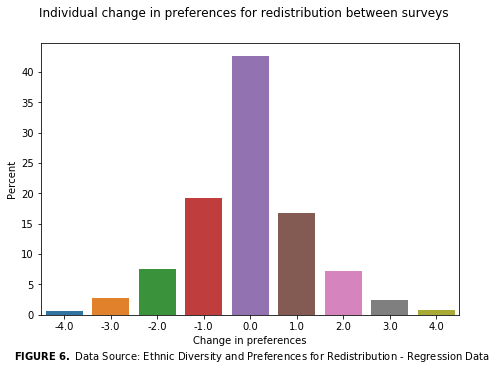

In [10]:
# plot histogram of change in preferences
fig, ax = plt.subplots(figsize=(7.5, 5))
ax = sns.barplot(x = df['soc_bidr_diff'], y = df['soc_bidr_diff'], estimator = lambda x: len(x) / len(df) * 100, color = None)
ax.set_ylabel('Percent')
ax.set_xlabel('Change in preferences')
plt.suptitle('Individual change in preferences for redistribution between surveys')
fig.text(0.075, 0,'$\\bf{FIGURE}$ $\\bf{6.}$ Data Source: Ethnic Diversity and Preferences for Redistribution - Regression Data');


As a last step, Table 1 provides summary statistics for the variables used in the empirical analysis. The data here is the final one that is used for the analysis below. It only considers the years where the program was in place and excludes the municipality with the large share of refugees placed relative to the population size. The statistics highlight the observations of the graphical analysis. On average the share of refugees received by the municipalities in the data set is somewhat below one percent and has a rather low standard deviation, which emphasises the equal distribution across the country. Furthermore, one also perceives the slight negative trend in preferences for redistribution. The mean of this variable is a bit below three, which means that people rather want to decrease the level of social benefits, and the average change in preferences for redistribution is negative.

In [11]:
# create copy of dataframe for placebo analysis in Section 
df_placebo = df.copy()

# adjust data for further analysis
# drop observations from panel 1982-85 as placement program hadn't yet started
df = df[df['year'] != 1985] 
# drop municipalities with large refugee inflow relative to population
df = df[df['flyktingandel'] <= 4] 
# add a constant to the model
df['const'] = 1

# sort data
df = df.sort_values(['kommun','year', 'id'], ascending = [True, True, True])

In [12]:
# descriptive statistics
df_stats = pd.DataFrame(columns = ['Variable', 'Mean', 'Standard Deviation', 'Minimum', 'Maximum'])
df_stats['Variable'] = ['Share of immigrants', 'Change in share of immigrants', 'Refugee inflow', 'Preferences for redistribution', 'Change in preferences for redistribution', 'Welfare spending (in 100 Swedish crowns)', 'Tax base (in 100 Swedish crowns)', 'Vacant housing rate', 'Unemployment rate', 'Population size (in 1000s)', 'Small-sized municipality', 'Large-sized municipality', 'Socialist majority in council', 'Presence of Green Party in council', 'Presence of New Democrats in council']
df_stats['Mean'] = [np.mean(df['nonOECDshare']), np.mean(df['nonOECDshare_diff']), np.mean(df['flyktingandel']), np.mean(df['soc_bidr']), np.mean(df['soc_bidr_diff']), np.mean(df['ekbistandpc']),np.mean(df['mskattekraft_t2']), np.mean(df['mean_hvac_share']), np.mean(df['mean_unempl']), np.mean(df['mbef']), np.mean(df['dsmastad']), np.mean(df['dstorstad']), np.mean(df['dsv_maj_1']), np.mean(df['dseatsmp_1']), np.mean(df['dseatsop_1'])]
df_stats['Standard Deviation'] = [np.std(df['nonOECDshare']), np.std(df['nonOECDshare_diff']), np.std(df['flyktingandel']), np.std(df['soc_bidr']), np.std(df['soc_bidr_diff']), np.std(df['ekbistandpc']),np.std(df['mskattekraft_t2']), np.std(df['mean_hvac_share']), np.std(df['mean_unempl']),  np.std(df['mbef']), np.std(df['dsmastad']), np.std(df['dstorstad']), np.std(df['dsv_maj_1']), np.std(df['dseatsmp_1']), np.std(df['dseatsop_1'])]
df_stats['Minimum'] = [np.min(df['nonOECDshare']), np.min(df['nonOECDshare_diff']), np.min(df['flyktingandel']), np.min(df['soc_bidr']), np.min(df['soc_bidr_diff']), np.min(df['ekbistandpc']),np.min(df['mskattekraft_t2']), np.min(df['mean_hvac_share']), np.min(df['mean_unempl']),  np.min(df['mbef']), np.min(df['dsmastad']), np.min(df['dstorstad']), np.min(df['dsv_maj_1']), np.min(df['dseatsmp_1']), np.min(df['dseatsop_1'])]
df_stats['Maximum'] = [np.max(df['nonOECDshare']), np.max(df['nonOECDshare_diff']), np.max(df['flyktingandel']), np.max(df['soc_bidr']), np.max(df['soc_bidr_diff']), np.max(df['ekbistandpc']), np.max(df['mskattekraft_t2']), np.max(df['mean_hvac_share']), np.max(df['mean_unempl']), np.max(df['mbef']), np.max(df['dsmastad']), np.max(df['dstorstad']), np.max(df['dsv_maj_1']), np.max(df['dseatsmp_1']), np.max(df['dseatsop_1'])]
 
# store results in latex table fragment
with open('Tables/table1_aux.tex', 'w') as tf:
    tf.write(df_stats.set_index('Variable').round(2).to_latex())

<img src="Tables/Table1.png" height="600" width="800" />


### **5. Treatment Effect Estimation** <a id='chap5'></a>

#### **5.1 Average Treatment Effect** <a id='chap5.1'></a>

As a first step, the average treatment effect of a one percentage point increase in the share of immigrants in the population on individual preferences for redistribution is estimated. 

As mentioned in Section 2, there is variable treatment intensity and Dahlberg et al. perform a two-stage least squares regression with the variable refugee inflow used as an instrument. Therefore, one can make use of a result by [Angrist and Imbens (1995)](#angimb) that tells us that under a few assumptions the ATE that is estimated corresponds to the average causal response (ACR). This is a generalisation of the local average treatment effect (LATE) to models with variable treatment intensity. The ACR is defined as the weighted average of the unit causal effects along the range of values of the treatment variable for those whose treatment status is affected by the instrument, the so called compliers. A unit causal effect is the difference in potential outcomes at a fixed level of treatment. The weights indicate the distribution of the compliers over the range of the treatment variable. The assumptions needed for this result to hold are conditional independence of the instrument of the potential outcomes of the treatment and dependent variables, respectively, as well as non-zero effect and monotonicity of the instrument.

The first assumption is fulfilled if the identifying assumption that conditional on municipal characteristics the refugee inflow has no effect on preferences for redistribution other than through its effect on the share of immigrants in the municipal population is correct. The other two are fulfilled as the placement of more refugees in a municipality always leads to a larger share of immigrants. 

The compliers at a given level of treatment are those municipalities that experience a higher treatment intensity due to the instrument. This means that the treatment effect estimate is valid for those municipalities whose share of immigrants in the population is increased due to the placement program, i.e. those who would have received fewer refugees otherwise. This might especially apply to smaller-sized municipalities as typically immigrants choose to live in larger towns. 

For the ACR estimation the following two-stage least squares regression is used: <a id='eq'></a>


\begin{align*}
& \text{(1)} \qquad  \Delta{IM}_{ms} = \alpha_0 + \alpha_1 \text{refugee inflow}_{ms} + \alpha_2 H_{ms} + \alpha_3 \Delta{Z}_{ms} + \alpha_4 \text{SIZE}_{ms}+ \alpha_5 \text{POL}_{ms} + \alpha_6 \text{SURVEY}_{s} + \epsilon_{ms} \\
& \text{(2)} \qquad \Delta{PREF}_{ims} = \beta_0 + \beta_1 \widehat{\Delta{IM}}_{ms} + \beta_2 H_{ms} + \beta_3 \Delta{Z}_{ms} + \beta_4 \text{SIZE}_{ms}+ \beta_5 \text{POL}_{ms} + \beta_6 \text{SURVEY}_{s} + \varepsilon_{ims} 
\end{align*}




The variables are defined as follows:

* $ \Delta{IM}_{ms} $ &nbsp;- &nbsp; change in the share of immigrants in municipality $m$ between survey waves $s-1$ and $s$
* $ \text{refugee inflow}_{ms} $ &nbsp; - &nbsp; total inflow of program refugees to municipality $m$ between survey waves $s-1$ and $s$ normalised by the average population size during that period
* $ \Delta{PREF}_{ims} $ &nbsp; - &nbsp; change in preferences for redistribution of individual $ i $ living in municipality $m$ between survey waves $s-1$ and $s$
* $ H_{ms} $ &nbsp; - &nbsp; vector of municipal unemployment rate and rate of vacant housing of municipality $m$ averaged over the panel period $s$
* $ \Delta{Z}_{ms} $ &nbsp; - &nbsp; vector of changes in unemployment rate, per capita social welfare expenditures, per capita tax base and population size of municipality $m$ between survey waves $s-1$ and $s$
* $ \text{SIZE}_{ms} $ &nbsp; - &nbsp; vector of dummy variables for large size and small size of municipality $m$ in panel period $s$
* $ \text{POL}_{ms} $ &nbsp; - &nbsp; vector of dummy variables for socialist majority, representation of Green Party and representation of populist right-wing party "New Democrats" in the council of municipality $m$ in panel period $s$
* $ \text{SURVEY}_{s} $ &nbsp; - &nbsp; survey panel fixed effect in panel period $s$

As described in Section 2, additional covariates for municipal characteristics have to be added to the model in order to identify a causal effect. The variables in $ H_{ms} $ are correlated with the refugee placement as the municipal contracts paid attention to local labour market and housing conditions. By controlling for changes in the state of the economy, $ \Delta{Z}_{ms} $, it is ensured that the increased ethnic diversity is the cause for the change in preferences for redistribution and not the fact that immigrants are typically welfare dependents and that their arrival leads to a heavier-burdened welfare system. Changes in the unemployment rate and per capita social welfare expenditures might also have a direct effect on preferences for redistribution of the local population. Moreover, the vector of political variables $ \text{POL}_{ms} $ accounts for the possibility that the views of different political parties affect the placement policy as well as preferences for redistribution among natives. A majority of the socialist party might lead to more social justice and generousity towards refugees, whereas the representation of the populist right-wing party "New Democrats" reflects a more nationalistic view that is likely to increase the negative attitude towards other ethnicities. As the parties are elected by the people, the representation in the council also reflects the view of the local population. Finally, the vectors of dummies $ \text{SIZE}_{ms} $ and $ \text{SURVEY}_{s} $ control for an effect of the population size and nationwide time trends, respectively.

For their regression, Dahlberg et al. make use of clustered standard errors with clusters defined as municipalities. In doing so, they account for the possibility of an unobserved municipality-level effect in the error term that is independent across different municipalities. This is reasonable since the treatment occurs at the municipality level and it is likely that for a given municipality there are other factors that are correlated with the treatment variable refugee inflow and also influence the dependent variable, but these factors do not need to be relevant for every municipality. This kind of clustering leads to 273 different clusters (actually there were 288 municipalities in 1994 but not all of them are represented in the data). The large amount of clusters might lead to correct-sized tests, as pointed out by [Bester et al. (2011)](#bester). So in a second step, to see whether the standard errors are affected, the authors repeat the analysis with standard errors clustered at county level, resulting in only 21 clusters. 

The following code performs the specified two-stage least squares regression for the two types of clustered standard errors. As the covariates used in the regressions are municipal variables only and also the instrument is measured at municipality level, the regressor matrix contains identical rows whenever two individuals from the same municipality and same year of observation are present in the data set. When using the original data set this results in a matrix that is singular and thus non-invertible. Locally, Python is able to circumvent the problem but the continuous integration service Travis CI always produces an error. Therefore, I ran the regressions locally and stored the results in a Latex table that is displayed below. The problem arises for every regression that is performed with the original data set, even if only a subset of the observations is considered. So I stored all the regressions and tests I perform with the original data set as functions in the auxiliary file 'regressions.py' and in the following, the calls of the corresponding functions are added as comments while the results are displayed in Latex tables again.

In [27]:
# 2SLS regression for average treatment effect estimate for two types of clustered standard errors
#main_reg(df)

<img src="Tables/Table2.png" height="600" width="600" />



Table 2 reveals that the estimate of the average causal response is $ \widehat{\beta_{1}} = - 0.3472$. This means that a one percentage point increase in the share of immigrants in the municipal population affects the average individual response by minus one third of a point in the five-point scale preference ordering. For both types of clustered standard errors, this result is significant at the five percent level.

Furthermore, the result of the first stage assures the relevance of the instrument in the full sample analysis, such that the weak instruments problem does not seem to be present here. The coefficient estimate of the variable refugee inflow is equal to $\widehat{\alpha_{1}} = 0.4973$, which means that the placement program explains approximately half of the variation in the change in the share of immigrants. According to [Olea and Pflueger (2013)](#olea) the strength of the instrument is ensured if the cluster robust F-statistic for $ H_{0}: \alpha_{1} = 0 $ is larger than 23.1. For standard errors clustered at municipality level the statistic is equal to 65.11 and for those clustered at county level it is even equal to 76.61. So there does not seem to be a weak instruments problem in the full sample.

In [22]:
# perform F-test for relevance of the instrument in the full sample
#F_stat1 = main_reg(df)[4].round(2)
#F_stat2 = main_reg(df)[5].round(2)
#print('The test statistic for standard errors clustered at municipality level is equal to {:3.2f}.'.format(F_stat1))
#print('The test statistic for standard errors clustered at county level is equal to {:3.2f}.'.format(F_stat2))

The test statistic for standard errors clustered at municipality level is equal to 65.11.
The test statistic for standard errors clustered at county level is equal to 76.61.


Comparing the results for the different types of clustered standard errors one can see that they are quite similar and do not affect the significance levels of most of the variables. Most importantly, the significance level of the treatment effect estimate and the coefficient of the instrument in the first stage are not affected at all. Even though it reduces the number of clusters, clustering on county level might result in misleading inference as the homoscedasticity assumption of the error term within counties might be too restrictive in view of the fact that the treatment occurs at the municipality level and not the county level. Therefore, in the following regressions only standard errors clustered at municipality level are used.

#### **5.2 Heterogeneous Treatment Effects** <a id='chap5.2'></a>

As outlined in Section 2, welfare dependents and welfare contributors are likely to have different views on preferences for redistribution. To estimate these heterogeneous treatment effects the authors make use of three different variables that are likely to explain the individual welfare dependency. These are the individual income, individual wealth and worker type status (white or blue collar) of the respondent. In the data income and wealth are divided into five classes and there exists a dummy for blue and white collar workers, respectively. So for the following analysis Dahlberg et al. construct three dummy variables for income, indicating whether the respondent belongs to the lowest of five income classes (roughly 15 percent of the individuals, denoted as $ \text{Income} < p15 $), the two lowest of five income classes (roughly 40 percent of the individuals, denoted as $ \text{Income} < p40 $) or to the highest income class (roughly 20 percent of the individuals, denoted as $ \text{Income} > p80 $). Similarly, three dummy variables for wealth are constructed, indicating whether the respondent belongs to the lowest of five wealth classes (roughly 40 percent of the individuals which have no wealth, denoted as $ \text{Wealth} < p40 $), to the two lowest of five wealth classes (roughly 60 percent of the individuals, denoted as $ \text{Wealth} < p60 $) or to the highest wealth class (roughly 15 percent of the individuals, denoted as $ \text{Wealth} > p85 $). So in the end there are eight dummy variables available for the heterogeneity analysis, two for worker type status and three for income and wealth, respectively. 

The two-stage least squares regression in [(1)](#eq) and [(2)](#eq) is then adjusted by interacting the variable refugee inflow and the change in share of immigrants $ \Delta{IM}_{ms} $ with one of the dummy variables, respectively, and also including the dummy on its own. 

In [13]:
# construct dummies for income and wealth classification
df['Income < p15'] = 0
df['Income < p40'] = 0
df['Income > p85'] = 0
df.loc[df['inc_cl15_t_1'] == 1, 'Income < p15'] = 1
df.loc[df['inc_cl15_t_1'] <= 2, 'Income < p40'] = 1
df.loc[df['inc_cl15_t_1'] == 5, 'Income > p85'] = 1

df['Wealth < p40'] = 0
df['Wealth < p60'] = 0
df['Wealth > p85'] = 0
df.loc[df['wealth_cl15_t_1'] == 1, 'Wealth < p40'] = 1
df.loc[df['wealth_cl15_t_1'] <= 2, 'Wealth < p60'] = 1
df.loc[df['wealth_cl15_t_1'] == 5, 'Wealth > p85'] = 1

# define interaction terms used for regression
df['Refugee inflow * (y < p15)'] = df['flyktingandel'] * df['Income < p15']
df['Refugee inflow * (y < p40)'] = df['flyktingandel'] * df['Income < p40']
df['Refugee inflow * (y > p85)'] = df['flyktingandel'] * df['Income > p85']
df['DeltaIM * (y < p15)'] = df['nonOECDshare_diff'] * df['Income < p15']
df['DeltaIM * (y < p40)'] = df['nonOECDshare_diff'] * df['Income < p40']
df['DeltaIM * (y > p85)'] = df['nonOECDshare_diff'] * df['Income > p85']

df['Refugee inflow * (w < p40)'] = df['flyktingandel'] * df['Wealth < p40']
df['Refugee inflow * (w < p60)'] = df['flyktingandel'] * df['Wealth < p60']
df['Refugee inflow * (w > p85)'] = df['flyktingandel'] * df['Wealth > p85']
df['DeltaIM * (w < p40)'] = df['nonOECDshare_diff'] * df['Wealth < p40']
df['DeltaIM * (w < p60)'] = df['nonOECDshare_diff'] * df['Wealth < p60']
df['DeltaIM * (w > p85)'] = df['nonOECDshare_diff'] * df['Wealth > p85']

df['Refugee inflow * white-collar'] = df['flyktingandel'] * df['tjman_t_1']
df['Refugee inflow * blue-collar'] = df['flyktingandel'] * df['arbetare_t_1']
df['DeltaIM * white-collar'] = df['nonOECDshare_diff'] * df['tjman_t_1']
df['DeltaIM * blue-collar'] = df['nonOECDshare_diff'] * df['arbetare_t_1']


In [10]:
# 2SLS regressions for heterogenous treatment effects 
#heterog_reg(df)

<img src="Tables/Table3.png" height="600" width="600" />



The heterogeneity analysis with respect to income in Table 3 reveals that the negative effect of increased immigration on the preferred level of social benefits is especially pronounced among high income earners. There is a statistically significant coefficient of $-0.8042$ of the interaction term, indicating that being in the highest income class reduces the support for redistribution by roughly 0.8 points more on the five-point scale ordering relative to respondents in other income classes. For the analysis with lower income classes however, one cannot find an additional effect of increased immigration on preferences for redistribution relative to others as the coefficient estimates of the interaction terms are not statistically significant at any conventional significance level.

<img src="Tables/Table4.png" height="600" width="600" />



Similar as for income, the heterogeneity analysis for wealth in Table 4 points out that the largest reduction in support for redistribution occurs for respondents in the top percentiles. The effect is even stronger than for income as being in the highest wealth class makes the negative effect of a one percentage point increase in immigration on preferences for redistribution approximately 1.25 larger in absolute value compared to the other classes. Now also the coefficient estimates for the lowest and two lowest classes are significant at the five and ten percent level, respectively, and indicate a movement in the other direction. Relative  to respondents in other classes, the effects are roughly 0.94 and 0.69 points larger, i.e. less negative, respectively.

<img src="Tables/Table5.png" height="600" width="600" />



Finally, Table 5 confirms the results already found as we see a statistically significant, more negative effect of a one percentage point increase in the share of immigrants on preferences for redistribution for white-collar workers relative to others. This is in line with the heterogeneity analysis with respect to income as white-collar workers are presumably also the high income earners. The corresponding estimate for blue-collar workers is also statistically significant at the ten percent level and confirms a less negative effect relative to others. 

To sum up, there is evidence for heterogeneous treatment effects with respect to welfare dependency. Those respondents who are likely welfare contributors are those whose support for redistribution is reduced the most when the population becomes more ethnically heterogeneous. Their treatment effect estimate is more negative than the ACR found in the last subsection. However, the exact treatment effect estimate for this group of the population depends on the definition of welfare dependency or whether income, wealth or worker-type status is a better indicator. For likely welfare dependents the conclusion is more difficult and it is not possible to find a consistent pattern of the direction and magnitude of the point estimate relative to the ACR in the different variables used for the analysis.

### **6. Placebo Analysis** <a id='chap6'></a>

To analyse the validity of the exogeneity assumption, the authors first perform a placebo analysis in treatment. If the refugee placement program is exogenous with respect to preferences for redistribution among the native population there should not be a correlation between preferences for redistribution in the panel period 1982/85 before the start of the program and the refugee inflow in subsequent panel periods. To test whether this is the case, the following two-stage least squares regression is performed: the changes in preferences for redistribution in the panel period 1982/85 are regressed on changes in the share of immigrants in the population during one of the three following program panel periods, instrumented by the refugee inflow in the corresponding panel, respectively. The covariates defined in Section 5.1 are included in the regressions as well.

In [14]:
# adjust data for further analysis
# only select observations from panel 1982/85
df_placebo = df_placebo[df_placebo['year'] == 1985]

# drop municipalities with large refugee inflow relative to population for one of the following panel periods
df_placebo = df_placebo[df_placebo['flyktingandel_tplus1'] <= 4] 
df_placebo = df_placebo[df_placebo['flyktingandel_tplus2'] <= 4] 
df_placebo = df_placebo[df_placebo['flyktingandel_tplus3'] <= 4] 

# add a constant to the model
df_placebo['const'] = 1

# sort data
df_placebo = df_placebo.sort_values(['kommun','year', 'id'], ascending = [True, True, True])

In [13]:
# 2SLS regression for placebo in treatment
#placebo_reg(df_placebo)

<img src="Tables/Table6.png" height="600" width="600" />


The estimation results in Table 6 show that there is indeed no correlation between preplacement preference trends and the refugee placement in subsequent panel periods, supporting the assumption of exogeneity of the program conditional on municipal covariates. The second stage coefficient estimates of the variable change in share of immigrants in all following periods is not statistically significant at any conventional significance level. An additional F-test for the joint significance of these three estimates results in a p-value of 0.77, indicating that we do not reject the null hypothesis that they are jointly zero.

In [23]:
# perform joint test of the three placebo treatments in the second stage regression
# return p-value of the test
#pvalue = placebo_reg(df_placebo)[3].round(2)
#print('The p-value of the test statistic is equal to {:3.2f}.'.format(pvalue))

The p-value of the test statistic is equal to 0.77.


### **7. Sensitivity Analyses** <a id='chap7'></a>

Even though the placebo analysis in Section 6 indicates that the assumption of exogeneity of the refugee placement program with respect to preferences for redistribution among the native population seems to be fulfilled for the underlying data set, the potential biases of the treatment effect estimate mentioned in Section 2 have to be investigated. In the following, each of them is treated separately. Additionally, a further cause of bias possibly arising as a result of the structure of the dataset is treated in subsection three.

#### **7.1 Potential bias due to refugees moving to another municipality after their initial placement** <a id='chap7.1'></a>

If refugees move to another municipality after their initial placement there are two potential causes for a bias. On the one hand, they might move to municipalities that are more generous towards immigrants. This leads to reverse causality and the estimates are likely to be upward biased, i.e. less negative than the population coefficient. This is because those individuals whose reaction to a more intense treatment would be more negative are not exposed to such a high treatment intensity. On the other hand, the number of refugees in a municipality will be mismeasured as the variable refugee inflow only takes the incoming ones into account. This leads to the fact that some municipalities are treated with more refugees than observed and some with less and biases now work in both directions. It is not possible to measure the migration of the refugees within Sweden to a full extent but [Dahlberg and Edmark (2008)](#dahled) investigate this kind of migration in a dataset containing roughly 20 percent of the refugees placed between 1987 and 1989. Out of those, 60 percent were still living in the municipality they were assigned to after four years and out of those who moved, 68 percent moved to or within one of the three big city counties Stockholm, Malmö, and Västra Götaland. It is a quite small sample to draw any inference about migration from and it is not certain that this pattern also applies to other years as well but nevertheless, it gives a first clue about the issue of refugee migration within Sweden. So as a first sensitivity analysis the authors reestimate the average treatment effect excluding the big city counties. It is likely that after the exclusion most of the municipalities that are taken into consideration are treated with less refugees than observed. As a result smaller effects are expected as we assume the estimate to be positively biased because a lower treatment intensity than assumed in the data leads to those estimates.

In [15]:
# adjust data frame for first sensitivity analysis
df_sens1 = df[df['bigcitycounty'] != 1]

# 2SLS regression excluding municipalities that are in one of the three big city counties 
#sens1_reg(df, df_sens1)

<img src="Tables/Table7.png" height="600" width="600" />



The results in Table 7 indicate that the point estimate of the average treatment effect is not affected that much and also the relevance of the instrument is still ensured. Both coefficients are significantly different from zero and similar to the ones of the full sample in Table 2. So even for this significantly smaller sample and with particular attention to the potential positive bias it is reasonable that there is a statistically significant negative effect of increased immigration on natives' preferred level of social benefits. Therefore, this sensitivity analysis suggests that the full sample analysis is still valid and a significantly negative effect of increased immigration on individual preferences for redistribution can indeed be found. But it relies on the assumption that the number of refugees placed in the small- and medium-sized municipalities is approximately valid and if it is different from the true value the difference only occurs in one direction, i.e. one always observes too many refugees in the data set compared to the number that is present in reality. Otherwise, one cannot argue that the bias of the treatment effect estimate is always positive.

#### **7.2 Potential bias due to municipalities refusing to take on refugees** <a id='chap7.2'></a>

If municipalities renegotiate with the Immigration Board to take on fewer refugees than originally contracted this might be an indication that those are least generous and positive towards immigrants. In this case the exogeneity assumption is likely to be not fulfilled as even after the inclusion of the municipal characteristics as covariates the decision to take up refugees might be correlated with changes in preferences for redistribution among the inhabitants. The bias is then expected to be positive as once again, the least generous are exposed to a lower treatment intensity. However, the authors report that such renegotiations only took place in the last years of the program period. So the exogeneity assumption is more likely to be fulfilled in the first years and therefore, the two-stage least squares regression is repeated without the panel 1991/94.

In [16]:
# adjust dataframe for second sensitivity analysis
df_sens2 = df[df['panel9194'] != 1]

# 2SLS regression excluding panel 91/94
#sens2_reg(df, df_sens2)

<img src="Tables/Table8.png" height="600" width="600" />



The results of this second sensitivity analysis in Table 8 prove the suggestion that the estimated effect considering the full sample may be positively biased. The negative effect of a one percentage point increase in the share of immigrants on the average individual's preferred level of social benefits is now even more pronounced and results in a reduction of almost one point on the five-point scale preference ordering. This means that the average treatment effect for the full sample might also be more negative than estimated in Section 5.1. However, looking at the coefficient estimate of refugee inflow in the first stage we see that it is considerably lower than for the full sample. It remains statistically significant at all levels but the refugee placement explains only slightly less than one third of the variation in the share of immigrants for the first years of the program. An F-test reveals that the relevance of the instrument is still ensured but the test statistic is now equal to 24.87 and thus significantly lower than for the full sample in Section 5.1 and very close to the critical value of 23.1.

In [26]:
# perform F-test for relevance of the instrument in the full sample
#F_stat = sens2_reg(df, df_sens2)[2]
#print('The F-test statistic is equal to {:3.2f}.'.format(F_stat))

The F-test statistic is equal to 24.87.


This reflects the fact that there might arise a problem with the relevance of the instrument for certain periods of the program. But overall, also this second sensitivity analysis shows that there is a statistically significant negative treatment effect. Furthermore, as the data set used for this analysis is more likely to fulfill the exogeneity assumption and the treatment effect estimate is considerably larger in absolute value, the treatment effect estimates found in Section 5.1 can be viewed as lower bounds in absolute value.

#### **7.3 Potential bias due to natives moving to another municipality as a result of the refugee inflow** <a id='chap7.3'></a>

Another problem that is not related to the exogeneity assumption but also threatens to bias the treatment effect estimate is the fact that only natives who live in the same municipality for both periods where they were interviewed are represented in the data set analysed. So if natives move to another municipality after the arrival of refugees this results in the fact that those people who are least generous towards immigrants are not taken into consideration in the data set. It is not possible to measure to how many people this applies and so no further analysis can be made regarding that point. But if it applies to some people the estimates will be positively biased again.

### **8. Simulation Study** <a id='chap8'></a>

So far only the threats to validity concerning the exogeneity assumption also addressed by the authors have been treated, but as specified in Section 2 there might be a measurement error in the instrument which could also bias the treatment effect estimate. The measurement error occurs because it is not possible to measure the exact number of incoming refugees and it is even intensified when there is a large extent of migration of the refugees within Sweden after the initial placement. To investigate how the first and second stage estimates are affected by a mismeasurement of the instrument, I perform a small simulation study in this section. 

The main idea is to generate two different variables for the refugee inflow in a given municipality and a given year, one of them being the true refugee inflow and one of them being the one that is observed, which corresponds to the true refugee inflow plus an error term. The first and second stages of the two-stage least squares regression in [(1)](#eq) and [(2)](#eq) are then reestimated, once using the generated variable for the true refugee inflow and once using the generated variable for the mismeasured refugee inflow. More precisely, I proceed as follows: 

**STEP 1 - Simulation of dataframe:**
At first, I extract the municipal variables except from refugee inflow and change in share of immigrants for each municipality and each year from the original dataframe used by the authors. These are then used to generate the absolute number of refugees arriving in the municipality in the specified panel period. Based on the information about the refugee placement program, I assume that the vacant housing rate, being a small-sized municipality and having a socialist majority in the council have a positive effect on the number of refugees placed, whereas the unemployment rate, being a large-sized municipality and the representation of the populist New Democrats in the council have a negative one. The variable further denoted as $ \text{true refugee inflow} $ is then constructed as the share of received refugees relative to the municipal population. Now the change in the share of immigrants by municipality and time is generated presuming that the true refugee inflow has a large positive influence of $0.8$ and additionally, the size of the municipal population plays a role. Finally, to account for the mismeasurement, an error term with standard deviation $ \sigma $ is added to the true refugee inflow, denoting this newly created variable as $ \text{measured refugee inflow} $. In a next step, I create a dataframe containing individual observations by sampling a municipality and a year for each individual and using the municipal characteristics obtained like that to construct the dependent variable change in preferences for redistribution for each individual. For this I assume that the change in the share of immigrants has a negative influence of $-0.35$ on the preferred level of social benefits and also a change in the population size, a change in welfare spending and the representation of the New Democrats in the council have a negative effect, whereas a change in the tax base, a change in the unemployment rate and a socialist majority have a positive one.

**STEP 2 - Reestimation of first and second stage:**
For a comparison of the estimation results with and without measurement error, I perform the two-stage least squares regression specified in [(1)](#eq) and [(2)](#eq) with the data set obtained in Step 1 once using the generated true refugee inflow as an instrument and once using the generated measured refugee inflow. To examine the influence of the scale of the measurement error, I repeat the procedure for different values of $ \sigma $, the standard deviation of the error term used to create the variable for measured refugee inflow. The values of $ \sigma $ used in this study range from 1 to 4 in intervals of 0.5. For a fixed value of $ \sigma $ this is done 100 times, each time creating a new data set like in Step 1, such that one arrives at 100 estimates of the first and second stage coefficients for given $\sigma $. 

In [17]:
# set seed for reproducibility
np.random.seed(1234)

In [18]:
##### STEP 1 ####

# generate basis of simulated data frames by selecting municipal characteristics from original dataframe
sim = df[['kommun', 'year', 'mskattekraft_t2', 'mbef', 'mean_hvac_share', 'mean_unempl', 'ekbistandpc', 'munempldiff', 'mskattekrdiff', 'mbefdiff', 'ekbistandpc_diff', 'dsv_maj_1', 'dseatsmp_1', 'dseatsop_1', 'dstorstad', 'dsmastad', 'panel8588', 'panel8891', 'panel9194', 'countykod', 'bigcitycounty', 'const']].copy()
# drop municipalities that appear repeatedly for the same year
sim.drop_duplicates(subset = ['kommun', 'year'], keep = 'first', inplace = True)
sim.reset_index(drop = True, inplace = True)
# rename columns
sim.columns = ['Municipality', 'Year', 'Tax base', 'Population size', 'Vacant housing rate', 'Unemployment rate', 'Welfare spending', 'Change in unemployment rate', 'Change in tax base', 'Change in population size', 'Change in welfare spending', 'Socialist majority', 'Representation of Green Party', 'Representation of New Democrats', 'Large-sized municipality', 'Small-sized municipality', 'Panel 85/88', 'Panel 88/91', 'Panel 91/94', 'County code', 'Big city county', "Constant"]

# write function that generates a simulated data frame
# input arguments: standard deviation of error term used to generate mismeasured refugee inflow, number of individual observations
def simulate(stand_dev, num_indiv):
    
    data = np.tile(np.nan, (len(sim), 3))
    
    for i in range(len(sim)):
        # store municipal variables from original dataframe
        obs = sim.iloc[i, :]
        
        ##########################################################
        ### generate municipal variables related to immigration ##
        ##########################################################
        ### generate variable refugee inflow for each municipality
        # specify number of refugees (in absolute value) placed by the program
        inflow = 25 - 4 * obs['Unemployment rate'] + 7 * obs['Vacant housing rate'] - 5 * obs['Large-sized municipality'] + 10 * obs['Small-sized municipality'] + 5 * obs['Socialist majority'] - 3 * obs['Representation of New Democrats'] + np.random.normal()
        # ensure that refugee inflow is non-negative
        if inflow < 0:
            inflow = abs(inflow) 
        # compute refugee inflow as percent of population
        inflow_share = inflow/obs['Population size']  
        
        
        ### generate change in share of immigrants for each municipality  
        Del_IM = 0.8 * inflow_share - 0.07 * obs['Small-sized municipality'] + 0.4 * obs['Large-sized municipality'] + abs(np.random.normal(2))
        
        
        ### generate measured refugee inflow (indicating a mismeasurement of the true inflow)
        inflow_measured = inflow_share + np.random.normal(loc = 0, scale = stand_dev)
        # make sure that variable is  non-negative
        if inflow_measured < 0:
            inflow_measured = abs(inflow_measured)
    
    
        data[i, :] = [inflow_share, Del_IM, inflow_measured]
        
    sim_help = pd.DataFrame(data, columns = ['Refugee inflow', 'Change in share of immigrants', 'Refugee inflow measured'])
        
    sim2 = pd.concat([sim, sim_help], axis = 1, sort = False)
    
    ###############################################################################
    ### generate dataframe with individual observations and dependent variable ####
    ###############################################################################
    # for each individual sample a municipality he belongs to and add municipal variables from sim2
    data_indiv = np.tile(np.nan, (num_indiv, 26))
    for k in range(num_indiv):
        # sample a municipality the individual belongs to
        mun = randint(0,640)
        # select corresponding municipal variables from simulation data frame 
        var = sim2.iloc[mun, :]
        
        ### generate variable for change in preferences for redistribution for each individual
        pref = -0.35 * var['Change in share of immigrants'] - 0.05 * var['Change in population size'] + 0.001 * var['Change in tax base'] - 0.001 * var['Change in welfare spending'] + 0.003 * var['Change in unemployment rate'] + 0.07 * var['Socialist majority'] - 0.008 * var['Representation of New Democrats'] + np.random.normal()
        
        data_indiv[k, :] = [var['Municipality'], var['Year'], var['Tax base'], var['Population size'], var['Vacant housing rate'], var['Unemployment rate'], var['Welfare spending'], var['Change in unemployment rate'], var['Change in tax base'], var['Change in population size'], var['Change in welfare spending'], var['Socialist majority'], var['Representation of Green Party'], var['Representation of New Democrats'], var['Large-sized municipality'], var ['Small-sized municipality'], var['Panel 85/88'], var['Panel 88/91'], var['Panel 91/94'], var['County code'], var['Big city county'], var['Constant'], var['Refugee inflow'], var['Change in share of immigrants'], var['Refugee inflow measured'], pref ]
        
    sim_indiv = pd.DataFrame(data_indiv, columns = ['Municipality', 'Year', 'Tax base', 'Population size', 'Vacant housing rate', 'Unemployment rate', 'Welfare spending', 'Change in unemployment rate', 'Change in tax base', 'Change in population size', 'Change in welfare spending', 'Socialist majority', 'Representation of Green Party', 'Representation of New Democrats', 'Large-sized municipality', 'Small-sized municipality', 'Panel 85/88', 'Panel 88/91', 'Panel 91/94', 'County code', 'Big city county', 'Constant', 'Refugee inflow', 'Change in share of immigrants', 'Refugee inflow measured', 'Change in preferences for redistribution'])
    
    # return simulated data frame
    return(sim_indiv)        

In [19]:
##### STEP 2 ####

# generate s independent simulation sets and estimate first stage, once using true refugee inflow and once using mismeasured one
# do that for different standard deviations of the error term in the variable for mismeasured refugee inflow

# number of simulations
s = 100

# standard deviations that are used for generating the mismeasured refugee inflow
stand_devs = [1, 1.5, 2, 2.5, 3, 3.5, 4]

# matrices to store coefficient estimates, standard errors, confidence interval lengths and F-statistics for different sigma
# a row contains the estimate for every simulated dataframe, with sigma held fixed
coefficients = np.zeros((len(stand_devs), s))
coefficients2 = np.zeros((len(stand_devs), s))
coefficients3 = np.zeros((len(stand_devs), s))
coefficients4 = np.zeros((len(stand_devs), s))
se = np.zeros((len(stand_devs), s))
se2 = np.zeros((len(stand_devs), s))
se3 = np.zeros((len(stand_devs), s))
se4 = np.zeros((len(stand_devs), s))
confint_length = np.zeros((len(stand_devs), s))
confint_length2 = np.zeros((len(stand_devs), s))
confint_length3 = np.zeros((len(stand_devs), s))
confint_length4 = np.zeros((len(stand_devs), s))
F_stat = np.zeros((len(stand_devs), s))
F_stat2 = np.zeros((len(stand_devs), s))

for k in stand_devs:    
    for j in range(s):
        ###### call function from Step 1 
        # each simulated dataframe contains 2000 observations
        sim_data = simulate(k, 2000)
    
        # reestimate first stage using true refugee inflow
        regressors = ['Constant', 'Vacant housing rate', 'Unemployment rate', 'Change in unemployment rate', 'Change in tax base', 'Change in population size', 'Change in welfare spending', 'Small-sized municipality', 'Large-sized municipality', 'Socialist majority', 'Representation of Green Party', 'Representation of New Democrats', 'Panel 88/91', 'Panel 91/94', 'Refugee inflow']
        regression = mt.reg(sim_data, y_name = 'Change in share of immigrants', x_name = regressors, cluster = 'Municipality')
        # store point estimate
        coefficients[stand_devs.index(k), j] = regression.beta['Refugee inflow']
        # store standard errors of point estimates
        se[stand_devs.index(k), j] = regression.se['Refugee inflow']
        # compute length of confidence interval
        ci_low = regression.ci_lo['Refugee inflow']
        ci_high = regression.ci_hi['Refugee inflow']
        confint_length[stand_devs.index(k), j] = ci_high - ci_low
        # perform F-test to test for weak instrument
        F_stat[stand_devs.index(k), j] = regression.Ftest('Refugee inflow')[0]
               
        # reestimate first stage using mismeasured refugee inflow
        regressors2 = ['Constant', 'Vacant housing rate', 'Unemployment rate', 'Change in unemployment rate', 'Change in tax base', 'Change in population size', 'Change in welfare spending', 'Small-sized municipality', 'Large-sized municipality', 'Socialist majority', 'Representation of Green Party', 'Representation of New Democrats', 'Panel 88/91', 'Panel 91/94', 'Refugee inflow measured']
        regression2 = mt.reg(sim_data, y_name = 'Change in share of immigrants', x_name = regressors2, cluster = 'Municipality')
        # store point estimate
        coefficients2[stand_devs.index(k), j] = regression2.beta['Refugee inflow measured']
        # store standard errors of point estimates
        se2[stand_devs.index(k), j] = regression2.se['Refugee inflow measured']
        # compute length of confidence interval
        ci_low2 = regression2.ci_lo['Refugee inflow measured']
        ci_high2 = regression2.ci_hi['Refugee inflow measured']
        confint_length2[stand_devs.index(k), j] = ci_high2 - ci_low2
        # perform F-test to test for weak instrument
        F_stat2[stand_devs.index(k), j] = regression2.Ftest('Refugee inflow measured')[0]       
        
        # perform IV regression with true refugee inflow as instrument
        exog = ['Constant', 'Vacant housing rate', 'Unemployment rate', 'Change in unemployment rate', 'Change in tax base', 'Change in population size', 'Change in welfare spending', 'Small-sized municipality', 'Large-sized municipality', 'Socialist majority', 'Representation of Green Party', 'Representation of New Democrats', 'Panel 88/91', 'Panel 91/94']
        iv = mt.ivreg(sim_data, y_name = 'Change in preferences for redistribution', x_name = 'Change in share of immigrants', z_name = 'Refugee inflow', w_name = exog, iv_method = '2sls', cluster = 'Municipality')
        # store point estimates
        coefficients3[stand_devs.index(k), j] = iv.beta['Change in share of immigrants']
        # store standard errors of point estimates
        se3[stand_devs.index(k), j] = iv.se['Change in share of immigrants']
        # compute length of confidence interval
        ci_low3 = iv.ci_lo['Change in share of immigrants']
        ci_high3 = iv.ci_hi['Change in share of immigrants']
        confint_length3[stand_devs.index(k), j] = ci_high3 - ci_low3

        # perform IV regression with mismeasured refugee inflow as instrument
        exog2 = ['Constant', 'Vacant housing rate', 'Unemployment rate', 'Change in unemployment rate', 'Change in tax base', 'Change in population size', 'Change in welfare spending', 'Small-sized municipality', 'Large-sized municipality', 'Socialist majority', 'Representation of Green Party', 'Representation of New Democrats', 'Panel 88/91', 'Panel 91/94']
        iv2 = mt.ivreg(sim_data, y_name = 'Change in preferences for redistribution', x_name = 'Change in share of immigrants', z_name = 'Refugee inflow measured', w_name = exog2, iv_method = '2sls', cluster = 'Municipality')
        # store point estimates
        coefficients4[stand_devs.index(k), j] = iv2.beta['Change in share of immigrants']
        # store standard errors of point estimates
        se4[stand_devs.index(k), j] = iv2.se['Change in share of immigrants']
        # compute length of confidence interval
        ci_low4 = iv2.ci_lo['Change in share of immigrants']
        ci_high4 = iv2.ci_hi['Change in share of immigrants']
        confint_length4[stand_devs.index(k), j] = ci_high4 - ci_low4



#### **8.1 Investigation of first stage estimation results** <a id='chap8.1'></a>

In a first step, I examine the consequences of the mismeasurement in the instrument on the coefficient estimate of the variable refugee inflow in the first stage. The true value used to generate the variable change in share of immigrants is equal to $0.8$ and one expects that an unbiased estimator is able to reveal this value in expectation. Therefore, Figure 7 compares the mean of the first stage coefficient estimates and the mean of the standard errors for those coefficient estimates over the single iterations for a given value of the standard deviation $ \sigma $.

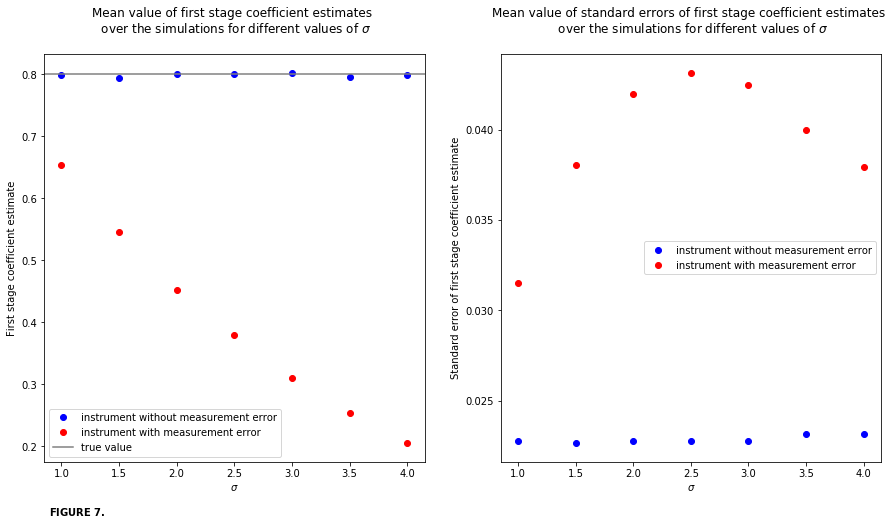

In [20]:
# compute means of estimated coefficients and their standard errors over simulations for each value of sigma
# using true refugee inflow
list_coeff = np.mean(coefficients, axis = 1)
list_se = np.mean(se, axis = 1)
# using mismeasured refugee inflow
list_coeff2 = np.mean(coefficients2, axis = 1)
list_se2 = np.mean(se2, axis = 1)

# create plots
fig7 = plt.figure(figsize = (15, 7.5))
plt.subplot(1,2,1)
plt.plot(stand_devs, list_coeff, 'bo', stand_devs, list_coeff2, 'ro')
plt.axhline(y = 0.8, color = 'grey', linestyle='-')
plt.title('Mean value of first stage coefficient estimates \n over the simulations for different values of $\sigma$ \n')
plt.ylabel('First stage coefficient estimate')
plt.xlabel('$ \sigma $')
plt.legend(['instrument without measurement error', 'instrument with measurement error', 'true value'])

plt.subplot(1,2,2)
plt.plot(stand_devs, list_se, 'bo', stand_devs, list_se2, 'ro')
plt.title('Mean value of standard errors of first stage coefficient estimates \n over the simulations for different values of $\sigma$ \n' )
plt.ylabel('Standard error of first stage coefficient estimate')
plt.xlabel('$ \sigma $')
plt.legend(['instrument without measurement error', 'instrument with measurement error'])
fig7.text(0.13, 0.025 , '$ \\bf{FIGURE} $ $ \\bf{7.} $ ');


One can see that using the variable true refugee inflow in the first stage, i.e. the one without measurement error, leads to an unbiased estimate of the effect of a one percentage point increase in refugee inflow on the change in the share of immigrants in the municipal population. But using the measured refugee inflow, i.e. the variable generated with measurement error, produces a bias against zero. As $ \sigma $ increases and the measurement error gets more severe, the bias gets larger and larger. The first stage regression is thus no longer able to estimate the influence of refugee inflow on the change in the share of immigrants in the municipal population correctly. The correlation between the measured refugee inflow and the change in share of immigrants decreases when $ \sigma $ increases as the coefficient estimates approach zero. This seems reasonable since the correlation between true and measured refugee inflow decreases as well in the presence of mismeasurement, since the influence of the error term gets larger and larger, and the change in share of immigrants has been generated using the true refugee inflow. Also the mean standard error of these coefficient estimates slightly increases when using the measured instead of the true refugee inflow. A consequence of the bias against zero of the coefficient estimates is the arising of a weak instruments problem when $ \sigma $ gets too large. A plot of the mean value of the F-statistic against the null-hypothesis that the instrument is irrelevant in the first stage for different values of $ \sigma $ in Figure 8 shows that the statistic decreases substantially the larger the measurement error gets. For the values of $ \sigma $ treated, the weak instrument problem does not arise yet as the F-statistic is always larger than 23.1, indicated by the gray line in the plot, but if we further increased the value of the standard deviation it would arise at some point. 

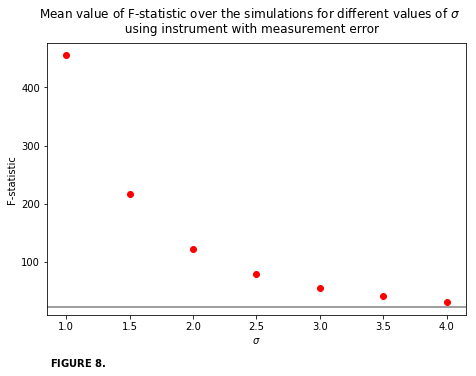

In [21]:
# compute means of F-statistics over simulations for each value of the standard deviation specified
# using true refugee inflow
list_Fstat = np.mean(F_stat, axis = 1)

# using mismeasured refugee inflow
list_Fstat2 = np.mean(F_stat2, axis = 1)

# plot means of F-statistics and add true value used in generation of data set
fig8, ax = plt.subplots(figsize = (7.5, 5))
ax = plt.plot(stand_devs, list_Fstat2, 'ro')
plt.axhline(y = 23.1, color = 'grey', linestyle='-')
plt.suptitle('Mean value of F-statistic over the simulations for different values of $\sigma$ \n using instrument with measurement error')
plt.ylabel('F-statistic')
plt.xlabel('$\sigma$')
fig8.text(0.13, -0.02 , '$ \\bf{FIGURE} $ $ \\bf{8.} $ ');



#### **8.2 Investigation of second stage estimation results** <a id='chap8.2'></a>

It turned out that a measurement error in the instrument has a significant influence on the first stage coefficient estimates. The question now is how or whether this bias in the first stage coefficient estimate carries over to the treatment effect estimate in the second stage. For that reason, Figure 9 plots the mean of the second stage coefficient estimates as well as the mean of the standard errors for those coefficient estimates over the single iterations against the value of the standard deviation $ \sigma $ and compares it with the true value of $-0.35$ used in the simulation. 

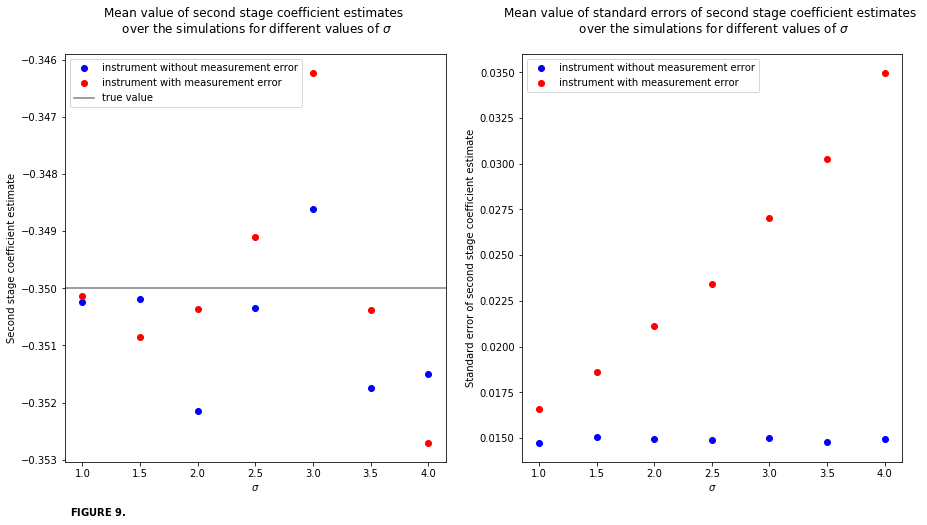

In [28]:
# compute means of estimated coefficients and their standard errors over simulations for each value of sigma
# using true refugee inflow
list_coeff3 = np.mean(coefficients3, axis = 1)
list_se3 = np.mean(se3, axis = 1)
# using mismeasured refugee inflow
list_coeff4 = np.mean(coefficients4, axis = 1)
list_se4 = np.mean(se4, axis = 1)

# create plots
fig7 = plt.figure(figsize = (15, 7.5))
plt.subplot(1,2,1)
plt.plot(stand_devs, list_coeff3, 'bo', stand_devs, list_coeff4, 'ro')
plt.axhline(y = -0.35, color = 'grey', linestyle='-')
plt.title('Mean value of second stage coefficient estimates \n over the simulations for different values of $\sigma$ \n')
plt.ylabel('Second stage coefficient estimate')
plt.xlabel('$ \sigma $')
plt.legend(['instrument without measurement error', 'instrument with measurement error', 'true value'])

plt.subplot(1,2,2)
plt.plot(stand_devs, list_se3, 'bo', stand_devs, list_se4, 'ro')
plt.title('Mean value of standard errors of second stage coefficient estimates \n over the simulations for different values of $\sigma$ \n' )
plt.ylabel('Standard error of second stage coefficient estimate')
plt.xlabel('$ \sigma $')
plt.legend(['instrument without measurement error', 'instrument with measurement error'])
fig7.text(0.13, 0.025 , '$ \\bf{FIGURE} $ $ \\bf{9.} $ ');



Comparing the estimates of the treatment effect in the second stage there is no huge difference using the true refugee inflow as an instrument to using the measured refugee inflow. For each value of $ \sigma $ the second stage coefficient estimates are very close to each other as they only differ at the third decimal place. Also the difference to the true value of -0.35 is very small for both instruments and each value of $ \sigma $ that is considered. An increase in $ \sigma $ does not cause the difference between the coefficient estimates of the correct and mismeasured instrument to become larger like it was the case in the first stage. Looking at the standard errors of those coefficient estimates, one can see a difference as the ones using the instrument with measurement error are larger than the ones using the true inflow. They also increase as the mismeasurement becomes more intense but overall they are still quite small.

So overall this simulation study suggests that the measurement error in the instrument does not affect the treatment effect estimate in the second stage although the first stage estimate is clearly influenced and the danger of a weak instruments problem arises when the standard deviation of the error term used to create the mismeasured instrument becomes too large. This implies that the validity of the treatment effect estimate with regard to measurement error in the instrument found in Section 5.1 seems to be assured. So even if the variable refugee inflow is incorrectly measured in the original data set, the presence of causal effect of a change in the share of immigrants on natives' preferences for redistribution found is reliable. Additionally, the measurement error for most of the municipalities in the data set might be less severe than simulated in this study such that the bias in the first stage results is also smaller. 

### **9. Conclusion** <a id='chap9'></a>

To sum up, the analyses performed by the authors suggest that there is a statistically significant negative effect of an increase in immigration on the support for redistribution among natives in Swedish municipalities where the immigrant share increased due to the refugee placement program. This negative effect is particularly valid and even more pronounced for typical welfare contributors in the society. Unfortunately, due to threats to validity concerning the exogeneity assumption of the instrument, the point estimate of the treatment effect for the full sample is not reliable. But the results of the sensitivity analyses in Section 7 suggest that all the potential biases would work against finding a statistically significant negative effect of an increase in immigration on natives' preferred level of social benefits. Therefore, Dahlberg et al. conclude that the average treatment effect estimate can be seen as a lower bound in absolute value of the true effect.

But even though a statistically significant causal effect can be found, the refugee placement program does not seem to be a good instrument. It is not a randomised experiment and even after conditioning on several municipal characteristics that played a role for the placement policy some problems are left. The municipalities were free to choose the refugees they wanted to take up if there were more applications than available places which results into selection on unobservables. One cannot control for that as there is no information in the data set about whether the municipalities were able to particularly select refugees and one also does not know anything about the characteristics of the refugees that were of importance in the selection process. As a result, the treatment effect estimates may be biased or inconsistent if the unobservable characteristics really influenced the placement policy. Additionally, the placement program is not able to explain the change in share of immigrants for the whole nation in the beginning as not every municipality took part. An even more severe problem is the application of the placement policy. As reported in Section 1.2, the enforcement was not always that strict and thus, it is likely that the refugees were able to choose themselves where to settle even in some years where the program was in place. As a consequence, reverse causality arises which biases the estimates and also the strength of the instrument is threatened. The problem is made even more severe as it is not possible to correctly measure the number of refugees placed by the program. Although the simulation study performed in Section 8 conjectures that such a mismeasurement in the instrument does not harm the validity of the treatment effect estimate in the second stage, one should be suspicious of the number of problems arising with the instrument. For that reason, it would be interesting to perform the analysis again using another instrument and then compare the results. Unfortunately, it is hard to find another valid instrument for the change in share of immigrants in a Swedish municipality.

### **References** <a id='ref'></a>

* Angrist, J. D., and Imbens, G. W. (1995). Two-stage Least Squares Estimation of Average Causal Effects in Models with Variable Treatment Intensity. Journal of the American Statistical Association, 90(430), 431-442. https://doi.org/10.1080/01621459.1995.10476535 <a id='angimb'></a>

* Angrist, J. D., and Pischke, J. Mostly harmless econometrics: An empiricists companion. Princeton, NJ: Princeton University Press, 2009 <a id='angpisch'></a>

* Bester, C.A., Conley, T., and Hansen, C.B.. (2011). Inference with Dependent Data Using Cluster Covariance Estimators. Journal of Econometrics, 165(2), 137-151. https://doi.org/10.1016/j.jeconom.2011.01.007 <a id='bester'></a>

* Dahlberg, M., and Edmark, K. (2008). Is there a 'Race-to-the-Bottom' in the Setting of Welfare Benefit Levels? Evidence from a Policy Intervention. Journal of Public Economics, 92(5-6), 1193-1209. https://doi.org/10.1016/j.jpubeco.2007.12.001 <a id='dahled'></a>

* Dahlberg, M., Edmark, K., and Lundqvist, H. (2012). Ethnic Diversity and Preferences for Redistribution. Journal of Political Economy, 120(1), 41-76. https://doi.org/10.1086/665800. <a id='paper'></a>



* Dahlberg, M., Edmark, K., and Lundqvist, H. (2012). Ethnic Diversity and Preferences for Redistribution - Graphic Data. Swedish National Data Service. Version 1.0. https://doi.org/10.5878/001110 <a id='graphdata'></a>

* Dahlberg, M., Edmark, K., and Lundqvist, H. (2012). Ethnic Diversity and Preferences for Redistribution - Regression Data. Swedish National Data Service. Version 1.0. https://doi.org/10.5878/001111 <a id='regdata'></a>

* Edin, P., Frederiksson, P., and Åslund, O. (2003). Ethnic Enclaves and the Economic Success of Immigrants - Evidence from a Natural Experiment. Quarterly Journal of Economics, 118, 329-357. https://doi.org/10.1162/00335530360535225 <a id='edin'></a>

* Nekby, L., and Pettersson‐Lidbom, P. (2016). Revisiting the relationship between ethnic diversity and preferences for redistribution: Comment. The Scandinavian Journal of Economics, 119(2), 268-287.  https://doi.org/10.1111/sjoe.12209 <a id='nekby'></a>

* Olea, J. L. M., and Pflueger, C. (2013) A Robust Test for Weak Instruments. Journal of Business & Economic Statistics, 31(3), 358-369 https://doi.org/10.1080/00401706.2013.806694 <a id='olea'></a>

* Statistics Sweden. From Finland to Afghanistan – immigration and emigration since 1970 for persons born in different countries. https://www.scb.se/en/finding-statistics/statistics-by-subject-area/population/population-projections/demographic-analysis-demog/pong/publications/from-finland-to-afghanistan--immigration-and-emigration-since-1970-for-persons-born-in-different-countries/ <a id='scb'></a>

* Wickström, M. (2015). The Multicultural Moment - The History of the Idea and Politics of Multiculturalism in Sweden in Comparative, Transnational and Biographical Context, 1964–1975. (Doctoral Thesis). Retrieved from Doria, National Library of Finland. https://www.doria.fi/handle/10024/103098 <a id='wickström'></a>

